## 1 a)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

def read_data_file(filename: str) -> pd.DataFrame:
    path = Path(os.getcwd() + 'q1.ipynb')
    data_folder = str(path.parent.absolute()) + '/data/'
    return pd.read_csv(data_folder + filename)


features = read_data_file('CATSnDOGS.csv') / 255 # Rescale features to values between 0 and 1
labels = read_data_file('Labels.csv')

models = [
          ('SVM', SVC()),
          ('LogReg', LogisticRegression(max_iter=1000)), 
          ('RF', RandomForestClassifier())
        ]

In [3]:
def evaluate_ensemble(models: list, features: pd.DataFrame, labels: pd.DataFrame) -> pd.DataFrame:
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, stratify=labels, random_state=None)
    dfs = []
    scoring = ['accuracy', 'precision', 'recall', 'f1']

    for name, model in models:
        kfold = StratifiedKFold(n_splits=9, shuffle=True, random_state=42)
        cross_validate(model, X_train, y_train.to_numpy().ravel(), cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train.to_numpy().ravel())
        y_pred = clf.predict(X_test)
        
        df = pd.DataFrame({'_id': y_test.index.values, 'true': y_test.to_numpy().ravel(), 'predicted': y_pred, 'model': name})
        dfs.append(df)

    result = pd.concat(dfs, ignore_index=True)
    return result


# want: mean and std for each scoring, for each model over iterations
def average_scores(models: list, features: pd.DataFrame, labels: pd.DataFrame, iter: int=5):
    matrix = []
    for it in range(iter):
        res = evaluate_ensemble(models, features, labels)
        scores = calc_scores(res)
        matrix.append(scores)
    
    mean = np.mean(matrix, axis=0)
    std = np.std(matrix, axis=0)
    return mean, std

    
# want: score for each scoring for each model
def calc_scores(ensemble_result: pd.DataFrame) -> np.ndarray:
    model_names = ensemble_result.model.unique()
    scores = np.zeros((len(model_names), 3))

    for i, name in enumerate(model_names):
        this_df = ensemble_result[ensemble_result.model == name]
        y_true = this_df['true']
        y_pred = this_df['predicted']

        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        cat_accuracy = tn / (tn + fp) # specificity
        dog_accuracy = tp / (tp + fn) # recall
        accuracy = (tn + tp)/(tn + fp + fn + tp)
        scores[i][0] = cat_accuracy
        scores[i][1] = dog_accuracy
        scores[i][2] = accuracy

    return scores


def detect_mislabels(models: list, features: pd.DataFrame, labels: pd.DataFrame, iter: int = 5, vote_limit: float = 0.5) -> dict:  
    mislabels = {}
    dfs = []

    for it in range(iter):
        res = evaluate_ensemble(models, features, labels)
        res['vote'] = np.absolute(res.true-res.predicted)
        dfs.append(res)

    df = pd.concat(dfs, ignore_index=True)
    model_names = df.model.unique()

    for i, name in enumerate(model_names):
        mislabelled_ids = []
        model_df = df[df.model == name]
        _ids = model_df._id.unique()

        for _id in _ids:
            _id_df = model_df[model_df._id == _id]
            total = len(_id_df.index)
            vote = _id_df['vote'].sum()
            
            if vote/total < vote_limit:
                continue
            else:
                mislabelled_ids.append(_id)

        mislabels[name] = mislabelled_ids

    return mislabels

mean, std = average_scores(models, features, labels, iter=10)
mislabels = detect_mislabels(models, features, labels, iter=10)

Are the cats and dogs well separated, i.e. can you obtain good classification test accuracy performance on this data set? Compare at least 3 classifiers.

_Answer:_

In [4]:
names = ['SVM', 'LogReg', 'RF']
for i, name in enumerate(names):
    print(name + " - mean accuracies (std) \n cat (specificity): %f (%f) \n dog (recall): %f (%f) \n overall: %f (%f) \n" % (mean[i][0], std[i,0], mean[i][1], std[i,1], mean[i][2], std[i,2]))

SVM - mean accuracies (std) 
 cat (specificity): 0.875000 (0.055902) 
 dog (recall): 0.757692 (0.078916) 
 overall: 0.814000 (0.026907) 

LogReg - mean accuracies (std) 
 cat (specificity): 0.816667 (0.056519) 
 dog (recall): 0.696154 (0.073882) 
 overall: 0.754000 (0.029732) 

RF - mean accuracies (std) 
 cat (specificity): 0.779167 (0.069846) 
 dog (recall): 0.742308 (0.084353) 
 overall: 0.760000 (0.036878) 



Are there any images that are consistently mislabeled by the classifiers (use resampling to ascertain)? 

Do the classifiers struggle with the same observations?

_Answer:_

In [5]:
mislabels_svm = set(mislabels['SVM'])
mislabels_logreg = set(mislabels['LogReg'])
mislabels_rf = set(mislabels['RF'])

intersection = mislabels_svm.intersection(mislabels_logreg).intersection(mislabels_rf)
all = [('SVM', mislabels_svm), ('LogReg', mislabels_logreg), ('RF', mislabels_rf)]
for name, mislabel in all:
    print("About %s percent of mislabels by the %s is shared by all models." % (np.around((len(intersection)/len(mislabel)*100), 2), name))

About 65.79 percent of mislabels by the SVM is shared by all models.
About 67.57 percent of mislabels by the LogReg is shared by all models.
About 56.82 percent of mislabels by the RF is shared by all models.


Why do you think these are difficult images to classify?

Are the errors balanced or is one class more difficult to classify correctly?

_Answer:_

Intersection: {131, 8, 139, 12, 14, 21, 151, 158, 162, 171, 176, 177, 54, 58, 63, 192, 85, 90, 93, 96, 98, 108, 112, 113, 117}
dog


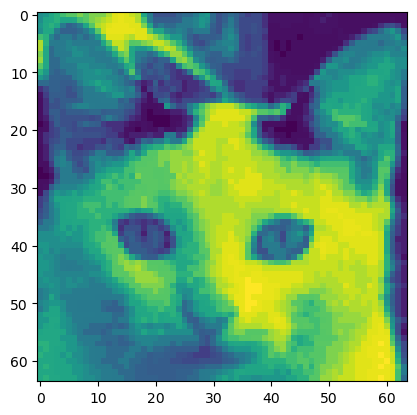

The data is mislabeled...
Fraction of missclassified dogs: 0.680000
Fraction of missclassified cats: 0.320000 
(according to algorithm)


In [9]:
print("Intersection: %s" % intersection)
_id = 8
sample = features.iloc[_id,:]
data = np.array(sample).reshape(64,64).T
plt.imshow(data, interpolation='nearest')
if labels.iat[_id,0] == 1:
    print("dog")
else:
    print("cat")
plt.show()

print("The data is mislabeled...")

tmp = labels.iloc[list(intersection), 0]
frac_mislabeled_dogs = tmp.sum() / len(tmp)
frac_mislabeled_cats = 1-tmp.sum() / len(tmp)
print("Fraction of missclassified dogs: %f" % frac_mislabeled_dogs)
print("Fraction of missclassified cats: %f \n(according to algorithm)" % frac_mislabeled_cats)


## 1 b)